# 0. About This Colab Notebook

1. This Colab is designed for the course "**Computer Programming in Python**" instructed by Tse-Yu Lin.

2. Note that each time you enter this Colab from the link provided by the instructor, TAs or other people.
Please create a copy to your own Google Drive by clicking **File > Save a copy in Drive**. After clicking, a new tab page will be opened.

In [ ]:
%matplotlib widget

import calendar
import json
import os
from itertools import combinations
from typing import Literal

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.text import Text

sns.set_theme(palette="pastel")

# a) Preparation: Download Dataset

We import the following package ``gdown`` to download files from Google Drive.

In [ ]:
filename = "disney_plus_titles.csv"
url = "https://drive.google.com/u/1/uc?id=118sEZB_-OfyXH130f-EED4KI26AXH8FO&export=download"
# mirror_url = "https://drive.google.com/u/1/uc?id=1xlzqH8z2ChAO4xPpm3GDfslyni53Bn5j&export=download"
try:
    if "google.colab" in str(get_ipython()):  # type: ignore
        import gdown  # type: ignore

        gdown.download(url, filename)
except NameError:
    pass

In [ ]:
raw_df = pd.read_csv(filename)

In [ ]:
m, n = raw_df.shape
print(f"Size of dataset: {m}")
print(f"Number of Features: {n}")

Size of dataset: 1450
Number of Features: 12


In [ ]:
raw_df.sample(n=5, random_state=42)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
538,s539,Movie,Homeward Bound II: Lost in San Francisco,David Ellis,"Robert Hays, Kim Greist, Veronica Lauren, Kevi...",United States,"May 1, 2020",1996,G,90 min,"Action-Adventure, Animals & Nature, Family",Three lost pets must navigate through San Fran...
754,s755,Movie,Boat Builders,Ben Sharpsteen,NaN,United States,"November 12, 2019",1938,TV-G,8 min,"Animation, Comedy, Family",Mickey and friends build a boat but it falls a...
49,s50,Movie,The Search for Santa Paws,Robert Vince,"Resse Alexander, Diedrich Bader, Sahar Biniaz,...",Canada,"November 5, 2021",2010,G,101 min,"Drama, Family, Fantasy",Discover how the legendary friendship of Santa...
1380,s1381,Movie,Toy Story Toons: Hawaiian Vacation,Gary Rydstrom,"Tom Hanks, Tim Allen, Joan Cusack, Kristen Sch...",United States,"November 12, 2019",2011,G,6 min,"Animation, Comedy, Family",Ken and Barbie get the vacation of their dreams.
141,s142,TV Show,Cesar Millan: Better Human Better Dog,NaN,Dustin Rubin,NaN,"August 4, 2021",2021,TV-14,1 Season,"Animals & Nature, Docuseries, Family",Renowned Dog Behaviorist Cesar Millan transfor...


Please refer the following link for more detail about headers:
* Disney+ Movies and TV Shows: https://www.kaggle.com/datasets/shivamb/disney-movies-and-tv-shows

# b) Data Analysis on Your Own

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       1450 non-null   object
 1   type          1450 non-null   object
 2   title         1450 non-null   object
 3   director      977 non-null    object
 4   cast          1260 non-null   object
 5   country       1231 non-null   object
 6   date_added    1447 non-null   object
 7   release_year  1450 non-null   int64 
 8   rating        1447 non-null   object
 9   duration      1450 non-null   object
 10  listed_in     1450 non-null   object
 11  description   1450 non-null   object
dtypes: int64(1), object(11)
memory usage: 136.1+ KB


## Define Utility Functions

In [ ]:
def rotate_label(
    label: Text,
    rotation: float | Literal["vertical", "horizontal"],
    align: Literal["left", "center", "right"] = "right",
) -> None:
    """Rotates a given `Text` instance by `rotation` degrees.

    Args:
        label: The `Text` instance to rotate.
        rotation: The rotation in degrees.
        align: The horizontal alignment of the resulting object. Defaults to "right".
    """
    label.set_rotation(rotation)
    label.set_horizontalalignment(align)

In [ ]:
def to_edges(cast: list) -> list:
    # todo: add docs
    return list(combinations(sorted(set(cast)), 2))

---

## Clean the Data

In [ ]:
cleaned_df = (
    raw_df.drop(labels=["director", "description"], axis="columns")
    .dropna(subset=["rating", "date_added"], how="any", axis="index")
    .assign(
        date_added=pd.to_datetime(raw_df["date_added"], format="%B %d, %Y"),
        duration=raw_df["duration"].str.extract("([0-9]+)").astype(int),
        cast=raw_df["cast"].str.split(", "),
        country=raw_df["country"].str.split(", "),
        listed_in=raw_df["listed_in"].str.split(", "),
    )
    .set_index(keys=["type", "rating", "release_year", "date_added", "show_id"])
    .sort_index()
)

cleaned_df.info()
cleaned_df  # type: ignore

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1444 entries, ('Movie', 'G', 1937, Timestamp('2019-11-12 00:00:00'), 's1200') to ('TV Show', 'TV-Y7-FV', 2021, Timestamp('2021-04-02 00:00:00'), 's266')
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      1444 non-null   object
 1   cast       1255 non-null   object
 2   country    1228 non-null   object
 3   duration   1444 non-null   int32 
 4   listed_in  1444 non-null   object
dtypes: int32(1), object(4)
memory usage: 113.1+ KB


title  \
type    rating   release_year date_added show_id                                                   
Movie   G        1937         2019-11-12 s1200                   Snow White and The Seven Dwarfs   
                 1940         2019-11-12 s1130                                         Pinocchio   
                                         s884                                           Fantasia   
                 1941         2019-11-12 s1326                              The Reluctant Dragon   
                 1942         2019-11-12 s739                                              Bambi   
...                                                                                          ...   
TV Show TV-Y7-FV 1985         2021-06-18 s196                          Star Wars Vintage: Droids   
                 2015         2019-11-12 s1005         LEGO Star Wars: Resistance Rises (Shorts)   
                 2019         2019-11-12 s1214                                  Star Wars: Blips   
                 2020         2021-02-12 s301     Marvel Battleworld: Mystery of the Thanostones   
                 2021         2021-04-02 s266      Star Wars Vintage: Clone Wars 2D Micro-Series   

                                                                                               cast  \
type    rating   release_year date_added show_id                                                      
Movie   G        1937         2019-11-12 s1200    [Adriana Caselotti, Harry Stockwell, Lucille L...   
                 1940         2019-11-12 s1130    [Dickie Jones, Christian Rub, Cliff Edwards, E...   
                                         s884        [Deems Taylor, Walt Disney, Leopold Stokowski]   
                 1941         2019-11-12 s1326    [Robert Benchley, Gerald Mohr, Alan Ladd, Flor...   
                 1942         2019-11-12 s739                                                   NaN   
...                                                                                             ...   
TV Show TV-Y7-FV 1985         2021-06-18 s196     [Anthony Daniels, R2-D2, Lesleh Donaldson, And...   
                 2015         2019-11-12 s1005                                                  NaN   
                 2019         2019-11-12 s1214                                                  NaN   
                 2020         2021-02-12 s301     [Giles Panton, Rebecca Shoichet, Jesse Inocall...   
                 2021         2021-04-02 s266     [Mat Lucas, James Arnold Taylor, Tom Kane, Gre...   

                                                                   country  \
type    rating   release_year date_added show_id                             
Movie   G        1937         2019-11-12 s1200             [United States]   
                 1940         2019-11-12 s1130             [United States]   
                                         s884              [United States]   
                 1941         2019-11-12 s1326             [United States]   
                 1942         2019-11-12 s739              [United States]   
...                                                                    ...   
TV Show TV-Y7-FV 1985         2021-06-18 s196                          NaN   
                 2015         2019-11-12 s1005    [United States, Denmark]   
                 2019         2019-11-12 s1214             [United States]   
                 2020         2021-02-12 s301              [United States]   
                 2021         2021-04-02 s266                          NaN   

                                                  duration  \
type    rating   release_year date_added show_id             
Movie   G        1937         2019-11-12 s1200          84   
                 1940         2019-11-12 s1130          90   
                                         s884          126   
                 1941         2019-11-12 s1326          74   
                 1942         2019-11-12 s739           72   
.

---

## Plot Features Against Counts

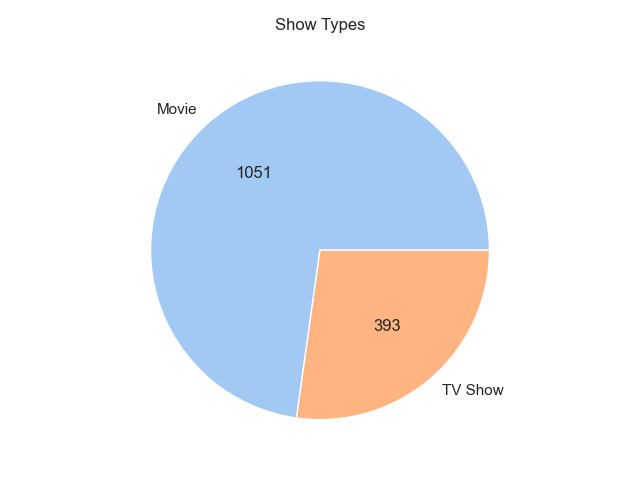

In [ ]:
data = cleaned_df["title"].groupby(level="type").count().sort_values(ascending=False)
fig, ax = plt.subplots()
ax.pie(
    x=data,
    labels=data.index.get_level_values("type"),  # type: ignore
    autopct=lambda x: int(x / 100 * data.sum()),
)
ax.set_title("Show Types")
_ = fig.tight_layout()

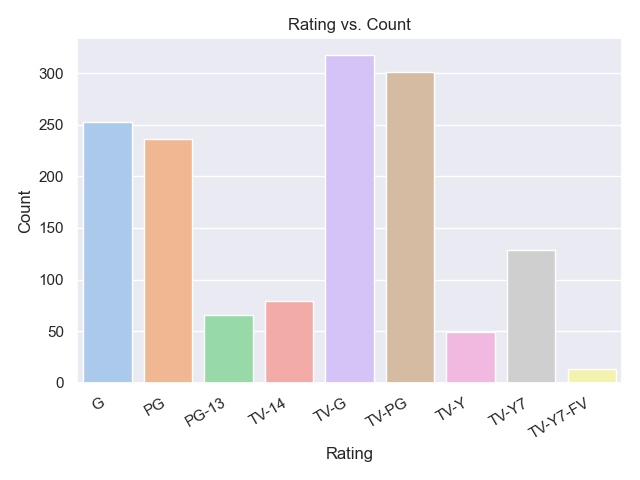

In [ ]:
fig, ax = plt.subplots()
sns.countplot(cleaned_df, x=cleaned_df.index.get_level_values("rating"), ax=ax)
ax.set_title("Rating vs. Count")
ax.set_xlabel("Rating")
ax.set_ylabel("Count")
{rotate_label(label, rotation=30) for label in ax.get_xticklabels()}
_ = fig.tight_layout()

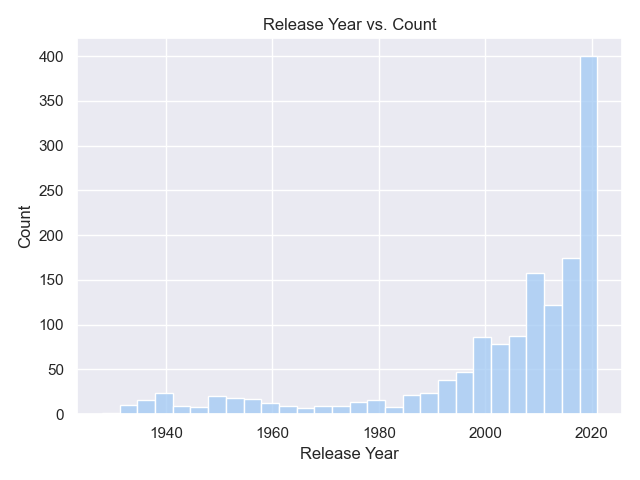

In [ ]:
fig, ax = plt.subplots()
sns.histplot(data=cleaned_df, x="release_year", ax=ax)
ax.set_title("Release Year vs. Count")
ax.set_xlabel("Release Year")
ax.set_ylabel("Count")
_ = fig.tight_layout()

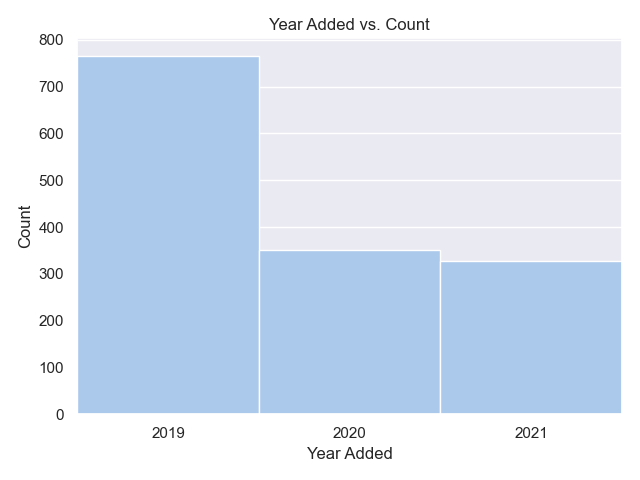

In [ ]:
data = cleaned_df.index.get_level_values("date_added").strftime("%Y-%m").sort_values()  # type: ignore
fig, ax = plt.subplots()
sns.countplot(
    x=data.str.extract("([0-9]+)").loc[:, 0],
    color=sns.color_palette()[0],  # type: ignore
    saturation=0.75,
    width=1.0,
    ax=ax,
)
ax.set_title("Year Added vs. Count")
ax.set_xlabel("Year Added")
ax.set_ylabel("Count")
_ = fig.tight_layout()

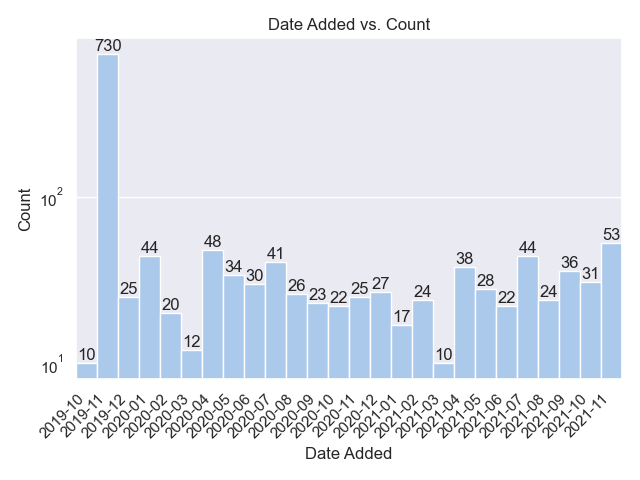

In [ ]:
fig, ax = plt.subplots()
sns.countplot(
    x=data,
    color=sns.color_palette()[0],  # type: ignore
    saturation=0.75,
    width=1.0,
    ax=ax,
)
ax.set_title("Date Added vs. Count")
ax.set_xlabel("Date Added")
ax.set_ylabel("Count")
ax.bar_label(ax.containers[0])  # type: ignore
ax.set_yscale("log")
{rotate_label(label, rotation=45) for label in ax.get_xticklabels()}
_ = fig.tight_layout()

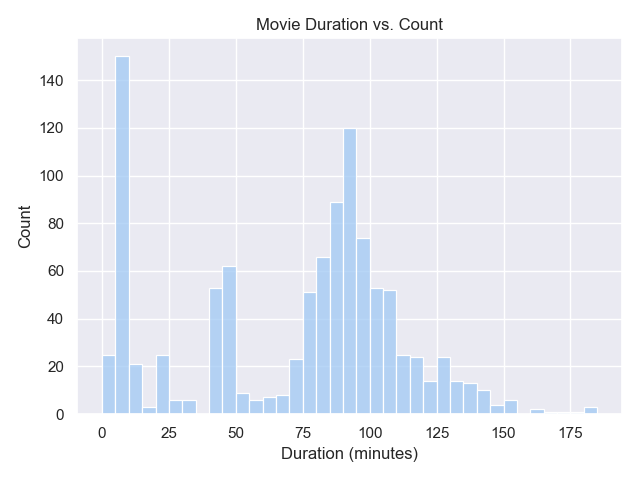

In [ ]:
data = cleaned_df[cleaned_df.index.get_level_values("type") == "Movie"]
fig, ax = plt.subplots()
ax = sns.histplot(data, x="duration", bins=185 // 5, binrange=(0, 185))  # type: ignore
ax.set_title("Movie Duration vs. Count")
ax.set_xlabel("Duration (minutes)")
ax.set_ylabel("Count")
_ = fig.tight_layout()

C:\Users\David\AppData\Local\Temp\ipykernel_29636\1853167289.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


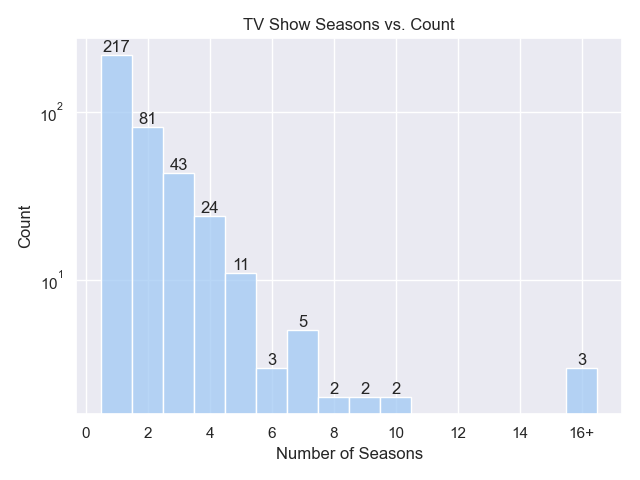

In [ ]:
data = cleaned_df[cleaned_df.index.get_level_values("type") == "TV Show"]
fig, ax = plt.subplots()
ax = sns.histplot(x=data["duration"].clip(0, 16), discrete=True, log_scale=(0, 10))
ax.set_title("TV Show Seasons vs. Count")
ax.set_xlabel("Number of Seasons")
ax.set_ylabel("Count")
ax.bar_label(ax.containers[1], labels=ax.containers[1].datavalues)

labels: list[Text] = ax.get_xticklabels()
labels[-2].set_text("16+")
ax.set_xticklabels(labels)
_ = fig.tight_layout()

Ignore NA values for country

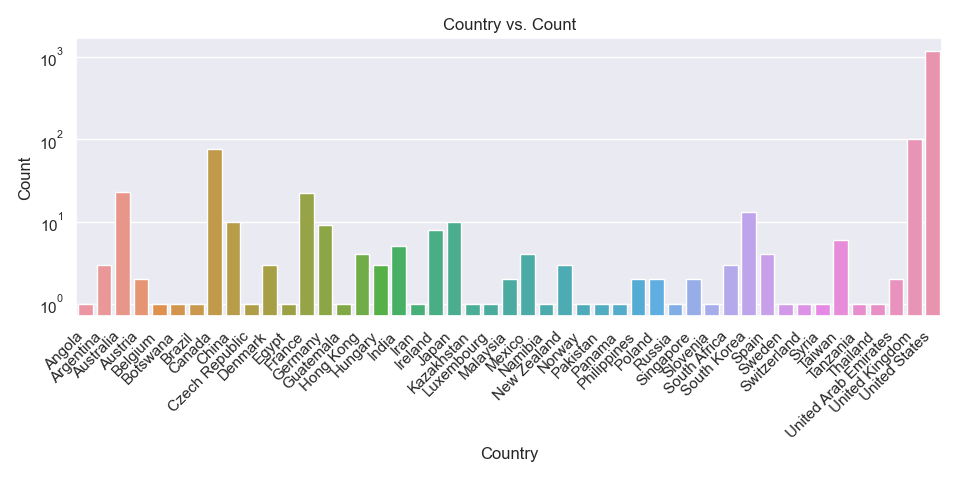

In [ ]:
data = cleaned_df["country"].dropna().explode().sort_values()
fig, ax = plt.subplots(figsize=(9.6, 4.8))
sns.countplot(x=data, ax=ax)
ax.set_title("Country vs. Count")
ax.set_xlabel("Country")
ax.set_ylabel("Count")
ax.set_yscale("log")
{rotate_label(label, 45) for label in ax.get_xticklabels()}
_ = fig.tight_layout()

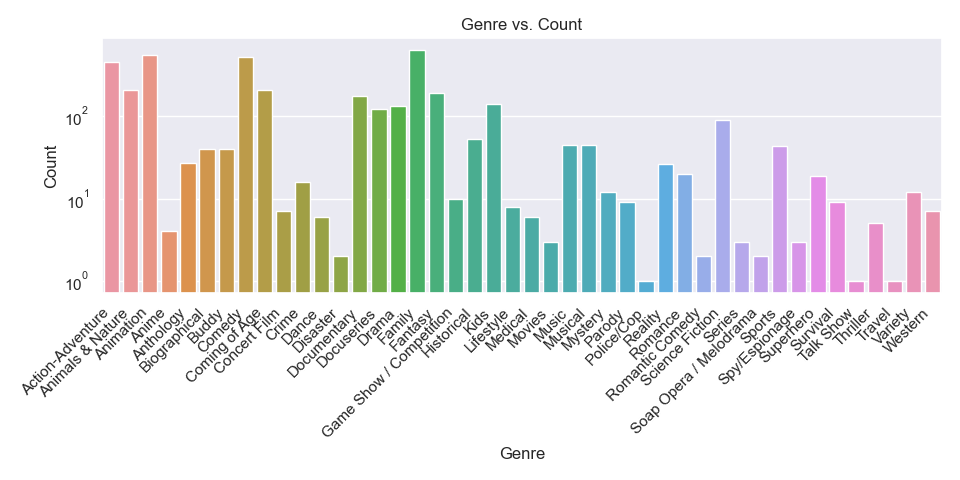

In [ ]:
data = cleaned_df["listed_in"].explode().sort_values()
fig, ax = plt.subplots(figsize=(9.6, 4.8))
sns.countplot(x=data, ax=ax)
ax.set_title("Genre vs. Count")
ax.set_xlabel("Genre")
ax.set_ylabel("Count")
ax.set_yscale("log")
{rotate_label(label, 45) for label in ax.get_xticklabels()}
_ = fig.tight_layout()

In [ ]:
data = cleaned_df["title"].str.len()
fig, ax = plt.subplots()
ax = sns.histplot(x=data)
ax.set_title("Title Length vs. Count")
ax.set_xlabel("Title Length (characters)")
ax.set_ylabel("Count")
_ = fig.tight_layout()

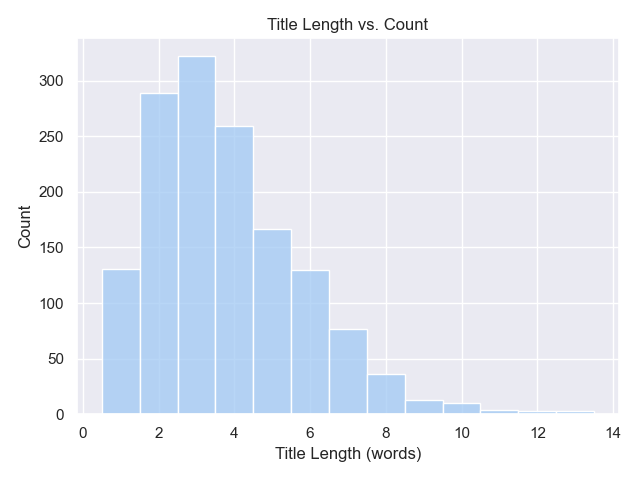

In [ ]:
data = cleaned_df["title"].str.findall(r"\w+").apply(len)
fig, ax = plt.subplots()
ax = sns.histplot(x=data, discrete=True)
ax.set_title("Title Length vs. Count")
ax.set_xlabel("Title Length (words)")
ax.set_ylabel("Count")
_ = fig.tight_layout()

### Ignore NA values for cast

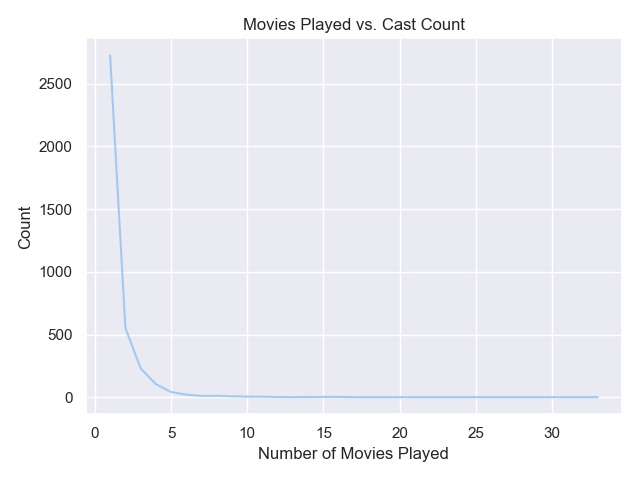

In [ ]:
data = cleaned_df[["cast"]].explode("cast").groupby("cast").size().value_counts()
fig, ax = plt.subplots()
ax = sns.lineplot(data)
ax.set_title("Movies Played vs. Cast Count")
ax.set_xlabel("Number of Movies Played")
ax.set_ylabel("Count")
_ = fig.tight_layout()

### Cast Connectivity Graph

In [ ]:
# find all edges between every cast and every other cast
edges_df: pd.DataFrame = (
    cleaned_df["cast"]
    .dropna()
    .reset_index(drop=True)
    .apply(to_edges)
    .explode(ignore_index=True)  # type: ignore
    .dropna()
    .apply(pd.Series)
    .rename(columns={i: v for i, v in enumerate(("source", "target"))})
    .convert_dtypes()
)
# set the weight of each edge as the number of occurrences of said edge
weighted_edges_df = pd.merge(
    edges_df.drop_duplicates(),
    edges_df.value_counts().rename("weight"),
    left_on=("source", "target"),
    right_index=True,
).sort_values("weight", ascending=False)
# create a graph from the weighted edges
G = nx.from_pandas_edgelist(weighted_edges_df, edge_attr=True)
# extract the largest subgraph
g = G.subgraph(max(nx.connected_components(G), key=len))

In [ ]:
# calculate nodes plotting positions
if "cast_graph_positions.json" not in os.listdir():

    class NumpyEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.ndarray):
                return {"__numpy__": list(obj)}
            return json.JSONEncoder.default(self, obj)

    pos = pd.DataFrame(
        nx.spring_layout(g, k=1 / (2 * np.sqrt(len(g))), iterations=1000, seed=42)
    )
    with open("cast_graph_positions.json", "w") as f:
        json.dump(pos, f, cls=NumpyEncoder)
else:

    def as_numpy(dct: dict) -> np.ndarray | dict:
        if "__numpy__" in dct:
            return np.array(dct["__numpy__"])
        return dct

    with open("cast_graph_positions.json") as f:
        pos = json.load(f, object_hook=as_numpy)
pos_df = pd.DataFrame(pos).T

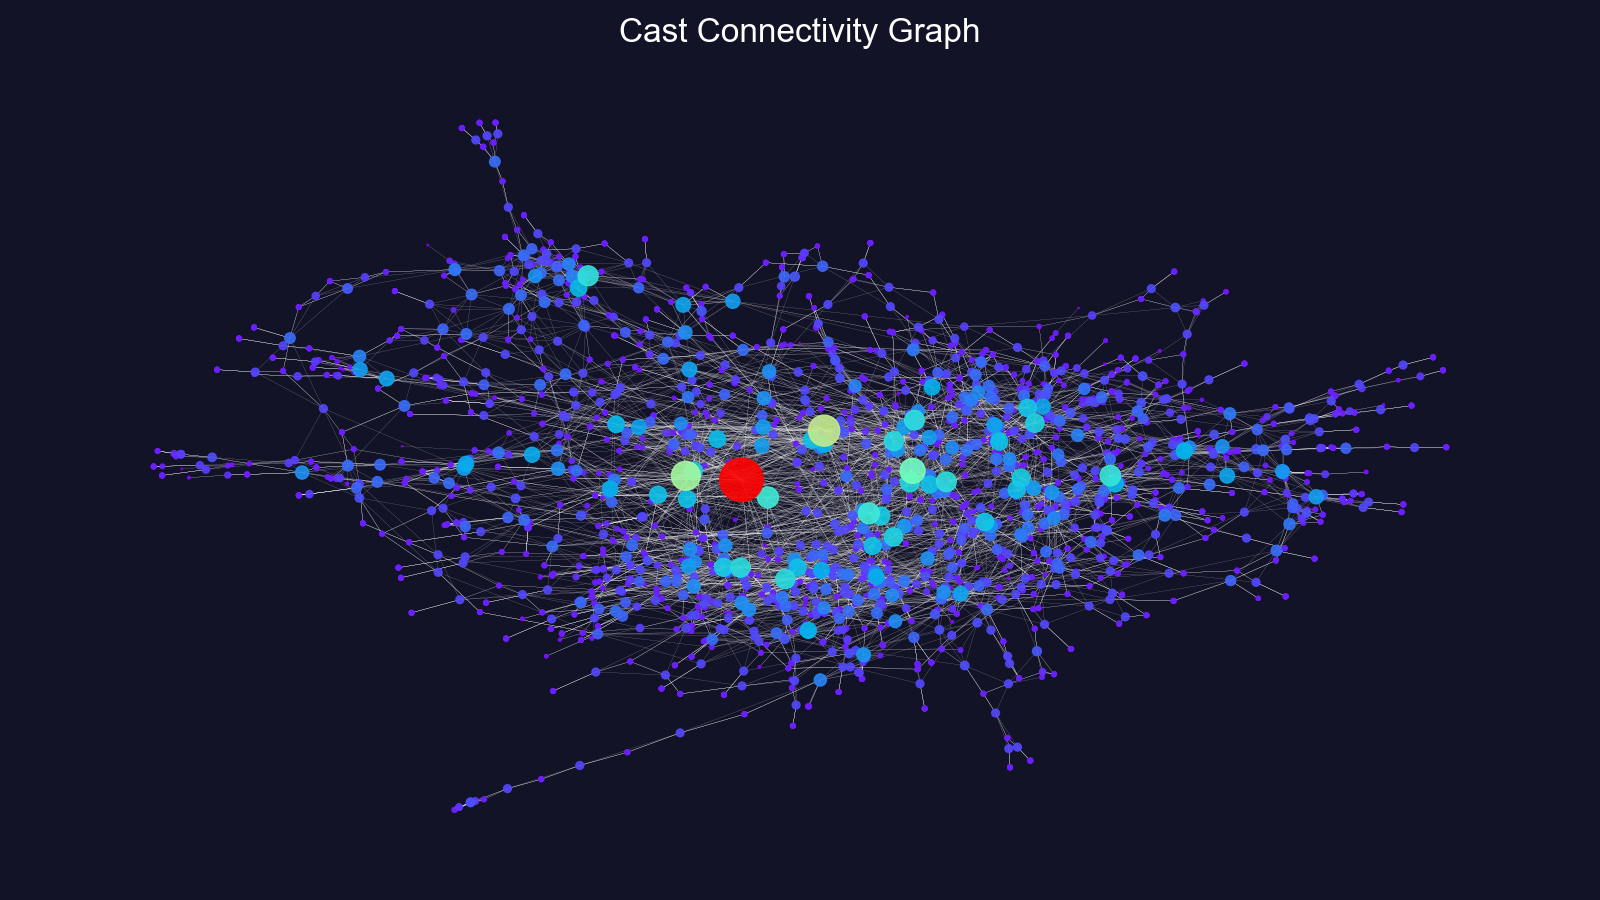

In [ ]:
# transform `pos_df`
transformed_pos_df = pos_df.sub(pos_df.loc["Jim Cummings"]).apply(
    lambda x: x / (np.dot(x, x) ** 0.2 + 1e-8), axis="columns"
)

node_degree = pd.DataFrame(g.degree, columns=["cast", "degree"]).sort_values("degree")

# plot the network
fig, ax = plt.subplots(figsize=(16, 9))
nx.draw_networkx(
    g,
    pos=transformed_pos_df.T.to_dict(orient="list"),
    ax=ax,
    alpha=0.9,
    cmap="rainbow",
    edge_color="white",
    node_color=[v for v in node_degree.loc[:, "degree"]],
    node_size=[v**1.5 for v in node_degree.loc[:, "degree"]],
    nodelist=node_degree.loc[:, "cast"],
    width=0.1,
    with_labels=False,
)
ax.axis("off")
ax.set_title("Cast Connectivity Graph", color="white", size=24)
fig.patch.set_facecolor("#131327")  # type: ignore
fig.tight_layout()
plt.savefig("test.svg", format="svg")

## Plot Multiple Features Against Counts

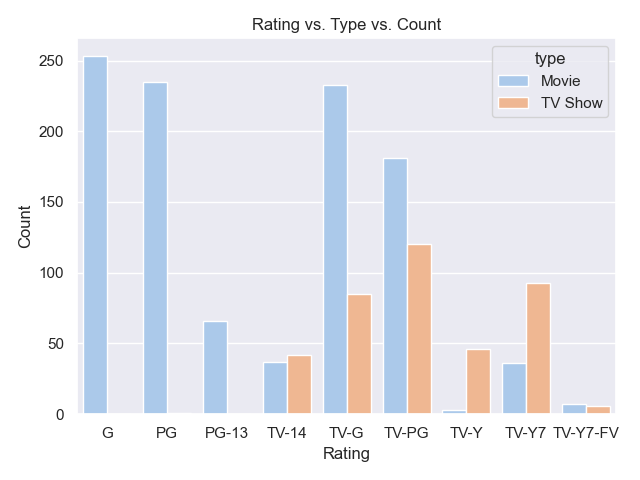

In [ ]:
fig, ax = plt.subplots()
sns.countplot(
    cleaned_df,
    x=cleaned_df.index.get_level_values("rating"),
    hue=cleaned_df.index.get_level_values("type"),
)
ax.set_title("Rating vs. Type vs. Count")
ax.set_xlabel("Rating")
ax.set_ylabel("Count")
_ = fig.tight_layout()

In [ ]:
cleaned_df[
    (cleaned_df.index.get_level_values("rating") == "PG")
    & (cleaned_df.index.get_level_values("type") == "TV Show")
]

,,,,,title,cast,country,duration,listed_in
type,rating,release_year,date_added,show_id,,,,,
TV Show,PG,2020,2021-08-04,s143,Walt Disney Animation Studios: Short Circuit E...,NaN,NaN,2,"[Animation, Anthology, Family]"


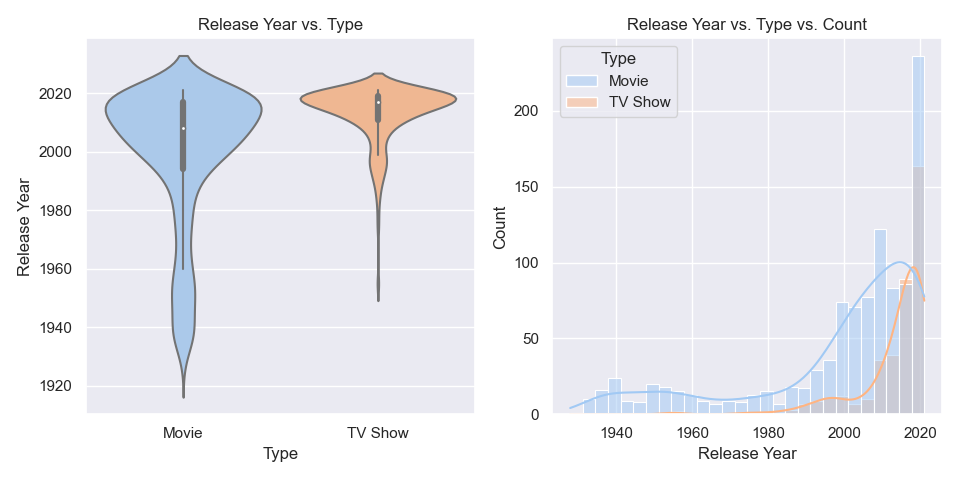

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9.6, 4.8))
sns.violinplot(
    x=cleaned_df.index.get_level_values("type"),
    y=cleaned_df.index.get_level_values("release_year"),
    scale="width",
    ax=axs[0],
)
axs[0].set_title("Release Year vs. Type")
axs[0].set_xlabel("Type")
axs[0].set_ylabel("Release Year")
p = sns.histplot(
    cleaned_df,
    x=cleaned_df.index.get_level_values("release_year"),
    hue=cleaned_df.index.get_level_values("type"),
    kde=True,
    ax=axs[1],
)
p.legend_.set_title("Type")
axs[1].set_title("Release Year vs. Type vs. Count")
axs[1].set_xlabel("Release Year")
axs[1].set_ylabel("Count")
_ = fig.tight_layout()

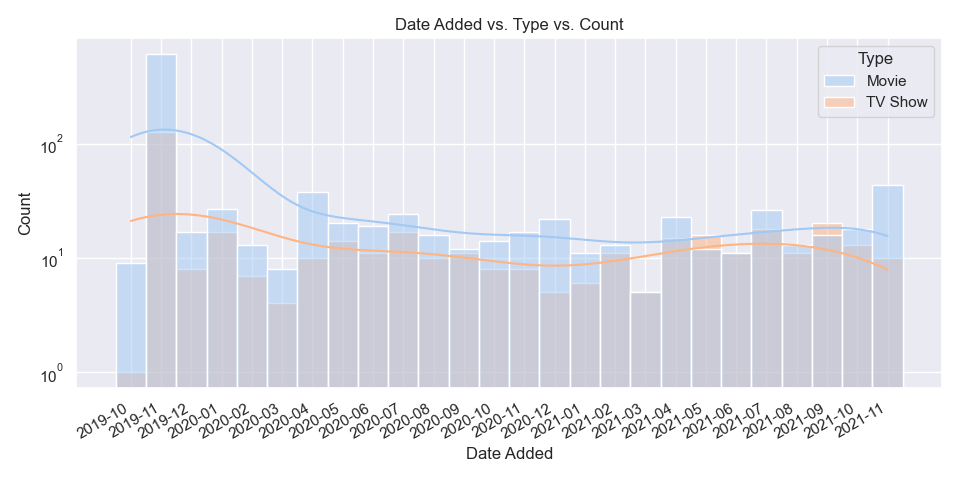

In [ ]:
fig, ax = plt.subplots(figsize=(9.6, 4.8))
data = cleaned_df.sort_index(level="date_added", sort_remaining=False)
months_added_df = data.index.get_level_values("date_added").strftime("%Y-%m")  # type: ignore
p = sns.histplot(
    data,
    x=months_added_df,
    hue=data.index.get_level_values("type"),
    discrete=True,
    kde=True,
    log_scale=(0, 10),
    ax=ax,
)
p.legend_.set_title("Type")
ax.set_title("Date Added vs. Type vs. Count")
ax.set_xlabel("Date Added")
ax.set_ylabel("Count")
{rotate_label(label, rotation=30) for label in ax.get_xticklabels()}
_ = fig.tight_layout()

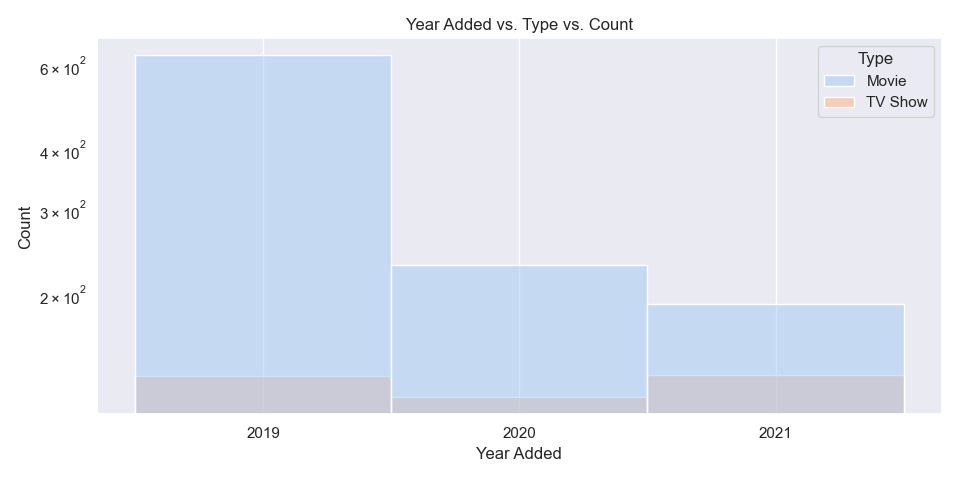

In [ ]:
fig, ax = plt.subplots(figsize=(9.6, 4.8))
data = cleaned_df.sort_index(level="date_added", sort_remaining=False)
months_added_df = data.index.get_level_values("date_added").strftime("%Y")  # type: ignore
p = sns.histplot(
    data,
    x=months_added_df,
    hue=data.index.get_level_values("type"),
    discrete=True,
    log_scale=(0, 10),
    ax=ax,
)
p.legend_.set_title("Type")
ax.set_title("Year Added vs. Type vs. Count")
ax.set_xlabel("Year Added")
ax.set_ylabel("Count")
_ = fig.tight_layout()

C:\Users\David\AppData\Local\Temp\ipykernel_32464\669040357.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(calendar.month_name[1:]))


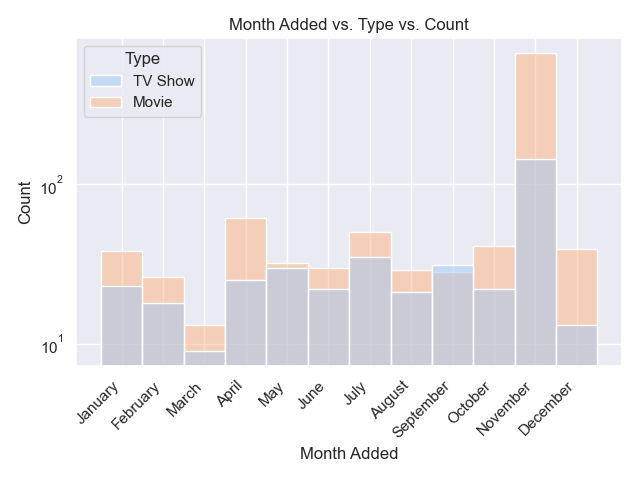

In [ ]:
fig, ax = plt.subplots()
data = cleaned_df.assign(
    **{"month_added": (cleaned_df.index.get_level_values("date_added").strftime("%m"))}  # type: ignore
).sort_values("month_added")
p = sns.histplot(
    data,
    x="month_added",
    hue=data.index.get_level_values("type"),
    discrete=True,
    log_scale=(0, 10),
    ax=ax,
)
p.legend_.set_title("Type")
ax.set_title("Month Added vs. Type vs. Count")
ax.set_xlabel("Month Added")
ax.set_ylabel("Count")
ax.set_xticklabels(list(calendar.month_name[1:]))
{rotate_label(label, rotation=45) for label in ax.get_xticklabels()}
_ = fig.tight_layout()